# 5. Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets import fetch_mldata, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

from prml import nn

np.random.seed(1234)

## 5.1 Feed-forward Network Functions

In [4]:
class RegressionNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Gaussian(h @ self.w2 + self.b2, std=1., data=y)
        return self.py.mu.value

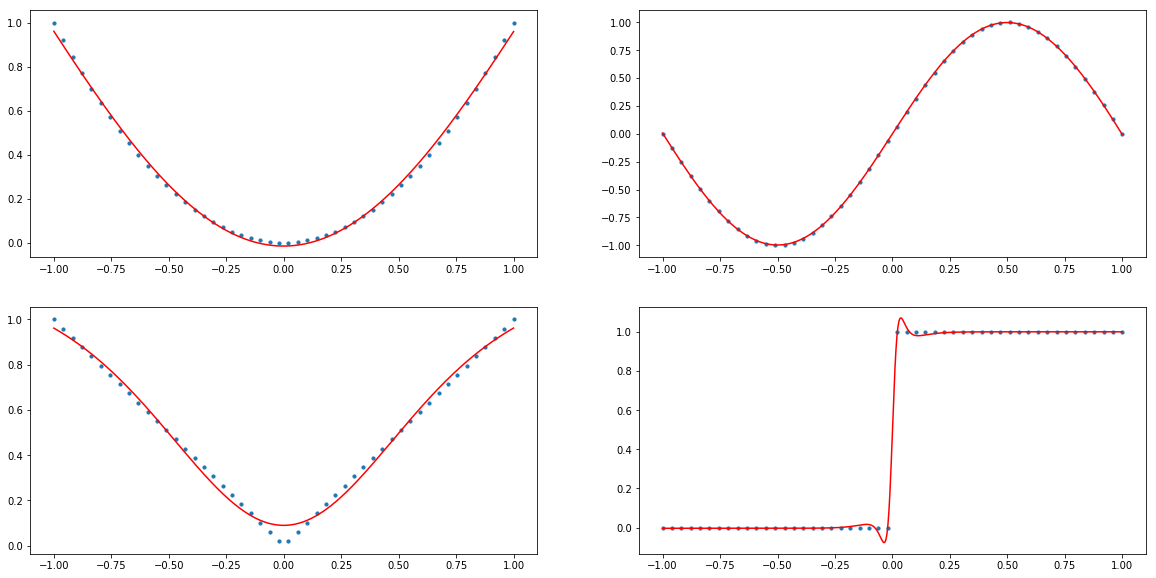

In [5]:
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter, decay_step in zip(range(1, 5), func_list, [1000, 10000, 10000, 10000], [100, 100, 1000, 1000]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = RegressionNetwork(1, 3, 1)
    optimizer = nn.optimizer.Adam(model, 0.1)
    optimizer.set_decay(0.9, decay_step)
    for _ in range(n_iter):
        model.clear()
        model(x_train, y_train)
        log_likelihood = model.log_pdf()
        log_likelihood.backward()
        optimizer.update()
    y = model(x)
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

## 5.3 Error Backpropagation

In [4]:
class ClassificationNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Bernoulli(logit=h @ self.w2 + self.b2, data=y)
        return self.py.mu.value

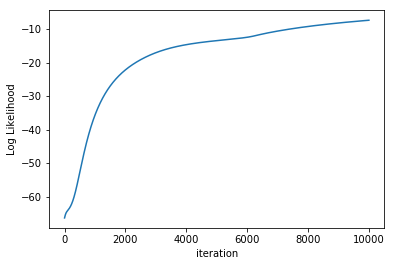

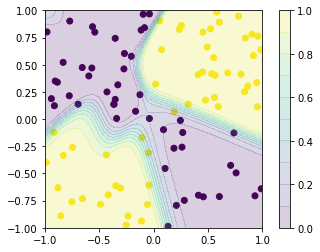

In [5]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = np.prod(x, axis=1) > 0
    return x, labels.reshape(-1, 1)


x_train, y_train = create_toy_data()
model = ClassificationNetwork(2, 4, 1)
optimizer = nn.optimizer.Adam(model, 1e-3)
history = []
for i in range(10000):
    model.clear()
    model(x_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()
    history.append(log_likelihood.value)
    
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("Log Likelihood")
plt.show()
    
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
y = model(x).reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.show()

## 5.5 Regularization in Neural Networks

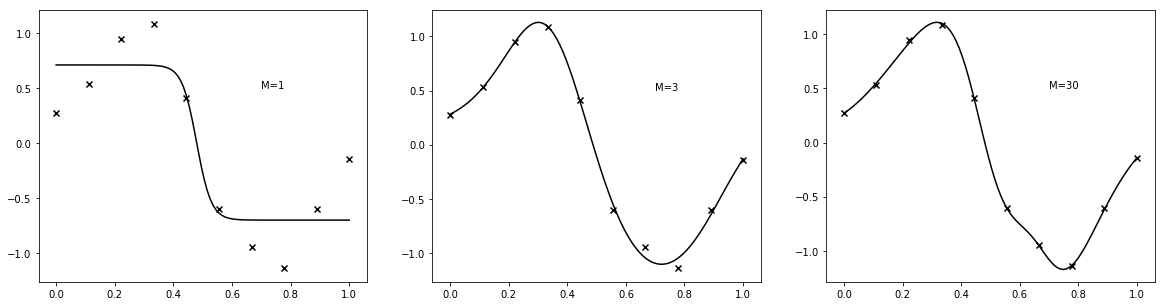

In [6]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))


x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None]

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = RegressionNetwork(1, m, 1)
    optimizer = nn.optimizer.Adam(model, 0.1)
    optimizer.set_decay(0.9, 1000)
    for j in range(10000):
        model.clear()
        model(x_train, y_train)
        log_posterior = model.log_pdf()
        log_posterior.backward()
        optimizer.update()
    y = model(x)
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

In [7]:
class RegularizedRegressionNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.pw1 = nn.random.Gaussian(0., 1., data=self.w1)
        self.pb1 = nn.random.Gaussian(0., 1., data=self.b1)
        self.pw2 = nn.random.Gaussian(0., 1., data=self.w2)
        self.pb2 = nn.random.Gaussian(0., 1., data=self.b2)
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Gaussian(h @ self.w2 + self.b2, std=0.1, data=y)
        return self.py.mu.value

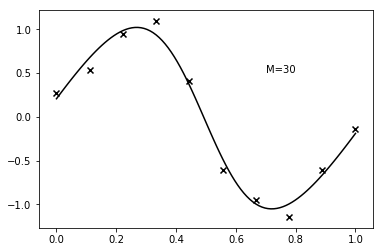

In [8]:
model = RegularizedRegressionNetwork(1, 30, 1)
optimizer = nn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 1000)
for i in range(10000):
    model.clear()
    model(x_train, y_train)
    log_posterior = model.log_pdf()
    log_posterior.backward()
    optimizer.update()
y = model(x)
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

In [9]:
def load_mnist():
    mnist = fetch_mldata("MNIST original")
    x = mnist.data
    label = mnist.target

    x = x / np.max(x, axis=1, keepdims=True)
    x = x.reshape(-1, 28, 28, 1)

    x_train, x_test, label_train, label_test = train_test_split(x, label, test_size=0.1)
    y_train = LabelBinarizer().fit_transform(label_train)
    return x_train, x_test, y_train, label_test
x_train, x_test, y_train, label_test = load_mnist()

In [10]:
class ConvolutionalNeuralNetwork(nn.Network):
    
    def __init__(self):
        truncnorm = st.truncnorm(a=-2, b=2, scale=0.1)
        super().__init__(
            w1=truncnorm.rvs((5, 5, 1, 20)),
            b1=np.zeros(20) + 0.1,
            w2=truncnorm.rvs((5, 5, 20, 20)),
            b2=np.zeros(20) + 0.1,
            w3=truncnorm.rvs((4 * 4 * 20, 500)),
            b3=np.zeros(500) + 0.1,
            w4=truncnorm.rvs((500, 10)),
            b4=np.zeros(10) + 0.1
        )
        
    def __call__(self, x, y=None):
        h = nn.relu(nn.convolve2d(x, self.w1) + self.b1)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        
        h = nn.relu(nn.convolve2d(h, self.w2) + self.b2)
        h = nn.max_pooling2d(h, (2, 2), (2, 2))
        
        h = h.reshape(-1, 4 * 4 * 20)
        h = nn.relu(h @ self.w3 + self.b3)
        
        self.py = nn.random.Categorical(logit=h @ self.w4 + self.b4, data=y)
        return self.py.mu.value

model = ConvolutionalNeuralNetwork()
optimizer = nn.optimizer.Adam(model, 1e-3)

while True:
    indices = np.random.permutation(len(x_train))
    for index in range(0, len(x_train), 50):
        model.clear()
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        prob = model(x_batch, y_batch)
        log_likelihood = model.log_pdf()
        if optimizer.n_iter % 100 == 0:
            accuracy = accuracy_score(
                np.argmax(y_batch, axis=-1), np.argmax(prob, axis=-1)
            )
            print("step {:04d}".format(optimizer.n_iter), end=", ")
            print("accuracy {:.2f}".format(accuracy), end=", ")
            print("Log Likelihood {:g}".format(log_likelihood.value))
        log_likelihood.backward()
        optimizer.update()
        if optimizer.n_iter == 1000:
            break
    else:
        continue
    break

step 0000, accuracy 0.14, Log Likelihood -133.503
step 0100, accuracy 0.88, Log Likelihood -19.0089
step 0200, accuracy 0.96, Log Likelihood -9.46796
step 0300, accuracy 0.90, Log Likelihood -15.0645
step 0400, accuracy 1.00, Log Likelihood -2.39944
step 0500, accuracy 0.92, Log Likelihood -4.48378
step 0600, accuracy 0.96, Log Likelihood -4.88767
step 0700, accuracy 0.94, Log Likelihood -7.86324
step 0800, accuracy 0.98, Log Likelihood -2.44538
step 0900, accuracy 0.98, Log Likelihood -2.71264


In [11]:
label_pred = []
for i in range(0, len(x_test), 50):
    label_pred.append(np.argmax(model(x_test[i: i + 50]), axis=-1))
label_pred = np.asarray(label_pred).ravel()
print("accuracy (test):", accuracy_score(label_test, label_pred))

accuracy (test): 0.969571428571


## 5.6 Mixture Density Networks

In [12]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [13]:
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_components):
        truncnorm = st.truncnorm(a=-0.2, b=0.2, scale=0.1)
        self.n_components = n_components
        super().__init__(
            w1=truncnorm.rvs((1, 5)),
            b1=np.zeros(5),
            w2_c=truncnorm.rvs((5, n_components)),
            b2_c=np.zeros(n_components),
            w2_m=truncnorm.rvs((5, n_components)),
            b2_m=np.zeros(n_components),
            w2_s=truncnorm.rvs((5, n_components)),
            b2_s=np.zeros(n_components)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        coef = nn.softmax(h @ self.w2_c + self.b2_c)
        mean = h @ self.w2_m + self.b2_m
        std = nn.exp(h @ self.w2_s + self.b2_s)
        self.py = nn.random.GaussianMixture(coef, mean, std, data=y)
        return self.py

In [14]:
model = MixtureDensityNetwork(3)
optimizer = nn.optimizer.Adam(model, 1e-4)

for i in range(30000):
    model.clear()
    batch = sample(x_train, y_train, n=100)
    model(x_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

In [3]:
x, y = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
xy = np.array([x, y]).reshape(2, -1).T

p = model(xy[:, 0].reshape(-1, 1), xy[:, 1].reshape(-1, 1))

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[0], p.coef.value[:100, 0], color="blue")
plt.plot(x[0], p.coef.value[:100, 1], color="red")
plt.plot(x[0], p.coef.value[:100, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[0], p.mu.value[:100, 0], color="blue")
plt.plot(x[0], p.mu.value[:100, 1], color="red")
plt.plot(x[0], p.mu.value[:100, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
prob = p.pdf().value
levels_log = np.linspace(0, np.log(prob.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, prob.reshape(100, 100), levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(p.coef.value[:100], axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[0, indices], p.mu.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

NameError: name 'x_train' is not defined

## 5.7 Bayesian Neural Networks

In [16]:
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]

In [17]:
class BayesianNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__(
            w1_m=np.zeros((n_input, n_hidden)),
            w1_s=np.zeros((n_input, n_hidden)),
            b1_m=np.zeros(n_hidden),
            b1_s=np.zeros(n_hidden),
            w2_m=np.zeros((n_hidden, n_hidden)),
            w2_s=np.zeros((n_hidden, n_hidden)),
            b2_m=np.zeros(n_hidden),
            b2_s=np.zeros(n_hidden),
            w3_m=np.zeros((n_hidden, n_output)),
            w3_s=np.zeros((n_hidden, n_output)),
            b3_m=np.zeros(n_output),
            b3_s=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.qw1 = nn.random.Gaussian(
            self.w1_m, nn.softplus(self.w1_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb1 = nn.random.Gaussian(
            self.b1_m, nn.softplus(self.b1_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qw2 = nn.random.Gaussian(
            self.w2_m, nn.softplus(self.w2_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb2 = nn.random.Gaussian(
            self.b2_m, nn.softplus(self.b2_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qw3 = nn.random.Gaussian(
            self.w3_m, nn.softplus(self.w3_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb3 = nn.random.Gaussian(
            self.b3_m, nn.softplus(self.b3_s),
            p=nn.random.Gaussian(0, 1)
        )
        h = nn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        h = nn.tanh(h @ self.qw2.draw() + self.qb2.draw())
        self.py = nn.random.Bernoulli(logit=h @ self.qw3.draw() + self.qb3.draw(), data=y)
        return self.py.mu.value

In [18]:
model = BayesianNetwork(2, 5, 1)
optimizer = nn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for i in range(2000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()

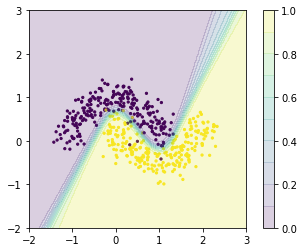

In [19]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y = np.mean([model(x_grid).reshape(100, 100) for _ in range(10)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=5)
plt.contourf(x1, x2, y, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()